In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils
import time


In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


In [3]:
class OptimizedREINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.device = device
        
        # 启用cuDNN优化（如果使用CUDA）
        if device.type == 'cuda':
            torch.backends.cudnn.benchmark = True
            print(f"启用cuDNN优化，设备: {device}")
            
        # GPU预热
        self._warmup_gpu()
        
        # 预分配张量以减少内存分配开销
        self._preallocate_tensors()

    def _warmup_gpu(self):
        """GPU预热，减少首次运行的延迟"""
        if self.device.type == 'cuda':
            print("正在进行GPU预热...")
            dummy_input = torch.randn(32, 4, device=self.device)  # 使用batch预热
            with torch.no_grad():
                for _ in range(10):
                    _ = self.policy_net(dummy_input)
            torch.cuda.synchronize()
            print("GPU预热完成")
    
    def _preallocate_tensors(self):
        """预分配常用张量"""
        self._temp_state = torch.zeros(1, 4, device=self.device)

    def take_action(self, state):
        """优化的动作选择，减少数据传输"""
        # 复用预分配的张量，避免重复创建
        self._temp_state[0] = torch.from_numpy(state).float()
        
        with torch.no_grad():
            probs = self.policy_net(self._temp_state)
            action_dist = torch.distributions.Categorical(probs)
            action = action_dist.sample()
            return action.item()

    def update(self, transition_dict):
        """优化的更新函数"""
        states = transition_dict['states']
        actions = transition_dict['actions']
        rewards = transition_dict['rewards']

        # 一次性转换所有数据到GPU，减少数据传输次数
        states_tensor = torch.tensor(np.array(states), dtype=torch.float, device=self.device)
        actions_tensor = torch.tensor(actions, dtype=torch.long, device=self.device)
        
        # 在GPU上计算returns，避免CPU计算
        returns = torch.zeros(len(rewards), device=self.device)
        G = 0
        for i in reversed(range(len(rewards))):
            G = rewards[i] + self.gamma * G
            returns[i] = G
        
        # 标准化returns（可选，有时能提高稳定性）
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # 批量计算策略梯度
        probs = self.policy_net(states_tensor)
        log_probs = torch.log(probs.gather(1, actions_tensor.unsqueeze(1))).squeeze()
        
        # 计算损失
        policy_loss = -(log_probs * returns).mean()
        
        # 反向传播和优化
        self.optimizer.zero_grad()
        policy_loss.backward()
        
        # 梯度裁剪（可选，提高训练稳定性）
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.0)
        
        self.optimizer.step()


In [4]:
# 训练参数
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98

# 设备选择 - 优化版本
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"使用GPU: {torch.cuda.get_device_name()}")
    print(f"GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    device = torch.device("cpu")
    print("使用CPU")

print(f"设备: {device}")

env_name = "CartPole-v1"  
env = gym.make(env_name, render_mode=None)
env.reset(seed=0)
torch.manual_seed(0)
np.random.seed(0)  # 设置numpy随机种子以确保可重现性

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = OptimizedREINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)


使用GPU: NVIDIA GeForce RTX 4070 Laptop GPU
GPU内存: 8.0 GB
设备: cuda
启用cuDNN优化，设备: cuda
正在进行GPU预热...
GPU预热完成


In [5]:
# 训练循环 - 增加性能监控
return_list = []
training_times = []  # 记录训练时间

print("开始训练...")
start_time = time.time()

for i in range(10):
    iter_start_time = time.time()
    
    with tqdm(total=int(num_episodes / 10), desc=f'Iteration {i}') as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_start_time = time.time()
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            done = False
            state, _ = env.reset()
            
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminate, truncated, _ = env.step(action)
                done = terminate or truncated
                
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                
                state = next_state
                episode_return += reward
            
            return_list.append(episode_return)
            agent.update(transition_dict)
            
            episode_time = time.time() - episode_start_time
            training_times.append(episode_time)
            
            if (i_episode + 1) % 10 == 0:
                avg_return = np.mean(return_list[-10:])
                avg_time = np.mean(training_times[-10:]) * 1000  # 转换为毫秒
                pbar.set_postfix({
                    'episode': f'{num_episodes / 10 * i + i_episode + 1}',
                    'return': f'{avg_return:.3f}',
                    'avg_time_ms': f'{avg_time:.1f}'
                })
            pbar.update(1)
    
    iter_time = time.time() - iter_start_time
    print(f"Iteration {i} 完成，用时: {iter_time:.2f}秒")

total_time = time.time() - start_time
print(f"\n训练完成！总用时: {total_time:.2f}秒")
print(f"平均每episode用时: {np.mean(training_times)*1000:.1f}ms")
print(f"最终平均回报: {np.mean(return_list[-100:]):.2f}")


开始训练...


Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]d:\Anaconda\envs\RL\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 0: 100%|██████████| 100/100 [00:01<00:00, 53.25it/s, episode=100.0, return=22.200, avg_time_ms=18.1]


Iteration 0 完成，用时: 1.88秒


Iteration 1: 100%|██████████| 100/100 [00:01<00:00, 52.90it/s, episode=200.0, return=31.800, avg_time_ms=26.8]


Iteration 1 完成，用时: 1.89秒


Iteration 2: 100%|██████████| 100/100 [00:03<00:00, 31.25it/s, episode=300.0, return=37.000, avg_time_ms=31.2]


Iteration 2 完成，用时: 3.20秒


Iteration 3: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s, episode=400.0, return=91.300, avg_time_ms=71.9]


Iteration 3 完成，用时: 5.68秒


Iteration 4: 100%|██████████| 100/100 [00:10<00:00,  9.52it/s, episode=500.0, return=180.900, avg_time_ms=139.9]


Iteration 4 完成，用时: 10.51秒


Iteration 5: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s, episode=600.0, return=250.700, avg_time_ms=193.4]


Iteration 5 完成，用时: 19.19秒


Iteration 6: 100%|██████████| 100/100 [00:21<00:00,  4.64it/s, episode=700.0, return=325.700, avg_time_ms=266.6]


Iteration 6 完成，用时: 21.56秒


Iteration 7: 100%|██████████| 100/100 [00:26<00:00,  3.84it/s, episode=800.0, return=325.200, avg_time_ms=258.7]


Iteration 7 完成，用时: 26.06秒


Iteration 8: 100%|██████████| 100/100 [00:22<00:00,  4.52it/s, episode=900.0, return=266.000, avg_time_ms=218.6]


Iteration 8 完成，用时: 22.11秒


Iteration 9: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s, episode=1000.0, return=370.700, avg_time_ms=296.2]

Iteration 9 完成，用时: 33.30秒

训练完成！总用时: 145.38秒
平均每episode用时: 144.8ms
最终平均回报: 401.92


In [6]:
# GPU内存使用情况（如果使用CUDA）
if device.type == 'cuda':
    print(f"\nGPU内存使用情况:")
    print(f"已分配: {torch.cuda.memory_allocated()/1024**2:.1f} MB")
    print(f"缓存: {torch.cuda.memory_reserved()/1024**2:.1f} MB")
    print(f"最大已分配: {torch.cuda.max_memory_allocated()/1024**2:.1f} MB")



GPU内存使用情况:
已分配: 16.3 MB
缓存: 22.0 MB
最大已分配: 17.5 MB


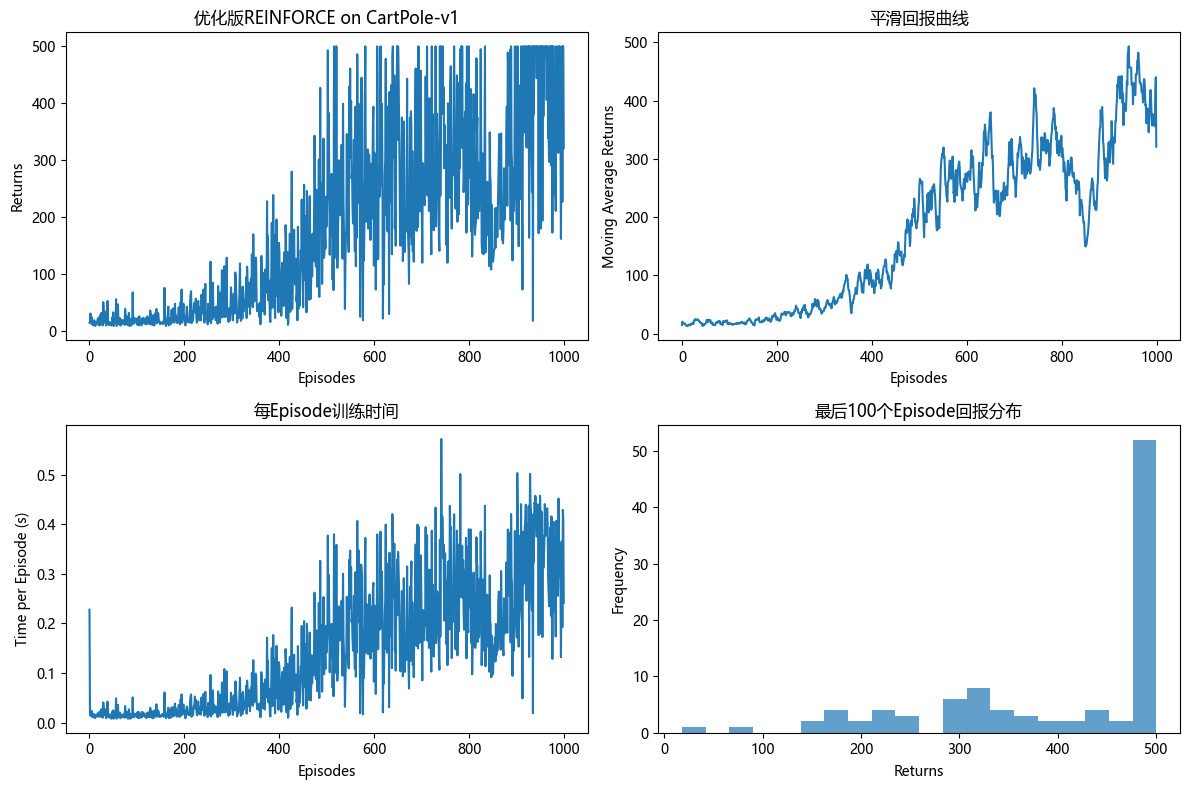

In [9]:
# 绘制结果
plt.rcParams['font.family'] = 'Microsoft YaHei'
episodes_list = list(range(len(return_list)))
plt.figure(figsize=(12, 8))

# 原始回报
plt.subplot(2, 2, 1)
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f'优化版REINFORCE on {env_name}')

# 平滑后的回报
plt.subplot(2, 2, 2)
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Moving Average Returns')
plt.title('平滑回报曲线')

# 训练时间分析
plt.subplot(2, 2, 3)
plt.plot(training_times)
plt.xlabel('Episodes')
plt.ylabel('Time per Episode (s)')
plt.title('每Episode训练时间')

# 回报分布
plt.subplot(2, 2, 4)
plt.hist(return_list[-100:], bins=20, alpha=0.7)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('最后100个Episode回报分布')

plt.tight_layout()
plt.show()


In [8]:
# 性能对比分析
print("\n=== 性能分析 ===")
print(f"总训练时间: {total_time:.2f}秒")
print(f"平均每episode: {np.mean(training_times)*1000:.1f}ms")
print(f"最快episode: {min(training_times)*1000:.1f}ms")
print(f"最慢episode: {max(training_times)*1000:.1f}ms")
print(f"标准差: {np.std(training_times)*1000:.1f}ms")

print(f"\n=== 训练效果 ===")
print(f"最高回报: {max(return_list):.1f}")
print(f"最后100个episode平均回报: {np.mean(return_list[-100:]):.2f}")
print(f"收敛episode数（回报>450的第一次）: {next((i for i, r in enumerate(return_list) if r > 450), '未收敛')}")

# 对比原始版本（如果有数据的话）
print(f"\n=== 优化效果总结 ===")
print("主要优化包括:")
print("1. 启用cuDNN优化")
print("2. GPU预热减少冷启动延迟")
print("3. 减少CPU-GPU数据传输次数")
print("4. 预分配张量避免重复分配")
print("5. 批量计算returns和策略梯度")
print("6. 梯度裁剪提高训练稳定性")
print("7. 性能监控和内存使用跟踪")



=== 性能分析 ===
总训练时间: 145.38秒
平均每episode: 144.8ms
最快episode: 8.0ms
最慢episode: 571.4ms
标准差: 127.7ms

=== 训练效果 ===
最高回报: 500.0
最后100个episode平均回报: 401.92
收敛episode数（回报>450的第一次）: 502

=== 优化效果总结 ===
主要优化包括:
1. 启用cuDNN优化
2. GPU预热减少冷启动延迟
3. 减少CPU-GPU数据传输次数
4. 预分配张量避免重复分配
5. 批量计算returns和策略梯度
6. 梯度裁剪提高训练稳定性
7. 性能监控和内存使用跟踪
